# Hydro-serving / Tensorflow

## Proposal
User trains model in genuine TF environment. We don't know where or how it's done. 
All we care about is a MetaGraphDef with serving Signatures.
Current notebook exploits Tensorflow Serving techniquies and upgrades them.

### Tensorflow Serving 
1. User trains model
2. User defines one or more signatures for graph.
3. User uses builder to export model.

Signatures in Tensorflow are limited: classification, prediction and regression signatures with input/output conditions.

### Hydro-serving
1. User trains model
2. User defines exactly one signature for graph.
3. User uses builder to export model.

As signature name user must use `tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY`.
There are no restrictions for input/output.

In [54]:
from __future__ import print_function
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil

In [3]:
# Import MNIST data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Epoch: 0001 cost= 157.567650833
Epoch: 0002 cost= 40.614061964
Epoch: 0003 cost= 25.145855488
Epoch: 0004 cost= 17.507262625
Epoch: 0005 cost= 12.603052658
Epoch: 0006 cost= 9.349792043
Epoch: 0007 cost= 6.964975329
Epoch: 0008 cost= 5.141477290
Epoch: 0009 cost= 3.829109068
Epoch: 0010 cost= 2.906461860
Epoch: 0011 cost= 2.165220779
Epoch: 0012 cost= 1.642120135
Epoch: 0013 cost= 1.244818602
Epoch: 0014 cost= 1.031664681
Epoch: 0015 cost= 0.840682691
Optimization Finished!
Accuracy: 0.9455


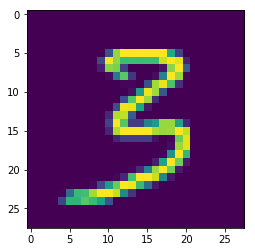

[3]
Exporting trained model to /tmp/tf_model...
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/tmp/tf_model/saved_model.pb'
Export finished


In [4]:
'''
A Multilayer Perceptron implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits
(http://yann.lecun.com/exdb/mnist/)
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

tf.reset_default_graph()

# Parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
display_step = 1

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_input], name="x")
y = tf.placeholder("float", [None, n_classes], name="y")


# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'], name = "out_classes")
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)
rand = tf.random_normal([2, 3], mean=-1, stddev=4)
output = tf.argmax(pred,1)
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            feed = {x: batch_x, y: batch_y}
            _, c = sess.run([optimizer, cost], feed_dict=feed)
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))
    batch_x = mnist.train.next_batch(1)[0][0].reshape(1, 784)
    
    plt.imshow(batch_x.reshape(28, 28))
    plt.show()
    
    bla = {
         'x:0': batch_x
    }
    print(sess.run(output, feed_dict=bla))
    
    export_path = "/tmp/tf_model"  
    print('Exporting trained model to {0}...'.format(export_path))

    shutil.rmtree(export_path)

    builder = tf.saved_model.builder.SavedModelBuilder(export_path)

    tensor_info_x = tf.saved_model.utils.build_tensor_info(x)
    tensor_info_output = tf.saved_model.utils.build_tensor_info(output)
    tensor_info_test = tf.saved_model.utils.build_tensor_info(rand)


    
    classification_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={
              'images': tensor_info_x
          },
          outputs={
              'labels': tensor_info_output,
              'labels2': tensor_info_output,
              'random': tensor_info_test
          },
          method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME)
    )
    
    legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
    builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: classification_signature
      },
      legacy_init_op=legacy_init_op)
    builder.save()
    print('Export finished')

INFO:tensorflow:Restoring parameters from b'/tmp/tf_model/variables/variables'
['images']
['labels', 'labels2', 'random']
<class 'list'>
<class 'numpy.ndarray'>
{'x:0': matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)}


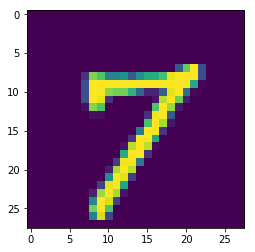

[{'labels': 8, 'labels2': 8, 'random': [6.999138832092285, -1.5135674476623535, 2.967315196990967], 'images': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.   

In [125]:
tf.reset_default_graph()

in_x, in_y = mnist.train.next_batch(1)
in2_x, in2_y = mnist.train.next_batch(1)
input_data = [
    {
        'images': in_x[0],
        'answer': in_y[0],
        "kek":1
    },
    {
        'images': in2_x[0],
        'answer': in2_y[0],
        "kek":2
    }
]

with tf.Session() as sess:
    meta_graph = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], export_path)
    signature = meta_graph.signature_def['serving_default']
    inputs = list(signature.inputs._values.keys())
    outputs = list(signature.outputs._values.keys())
    print(inputs)
    print(outputs)
    
    input_tensors = {x: sess.graph.get_tensor_by_name(signature.inputs[x].name) for x in inputs}
    output_tensors = {x: sess.graph.get_tensor_by_name(signature.outputs[x].name) for x in outputs}

    
    dicts = dict(zip(input_data[0], zip(*[d.values() for d in input_data])))
    
    feed_dict = {v.name: concatListOfArrs(list(dicts[k])) for (k, v) in input_tensors.items() }
    
    print(feed_dict)
    
#     plt.imshow(bla['x:0'].reshape(28, 28))
#     plt.show()
    
    result = sess.run(output_tensors, feed_dict)
    
    result = {k: v.tolist() if type(v) is np.ndarray else v for k, v in result.items() }
    
    res = dict(list(result.items()) + list(dicts.items()))
    res_list = [dict(zip(res,t)) for t in zip(*res.values())]
    
    print(res_list)

In [92]:
in_x, in_y = mnist.train.next_batch(1)
in2_x, in2_y = mnist.train.next_batch(1)
input_data = [
    {
        'images': in_x[0],
        'answer': in_y[0],
        "kek":1
    },
    {
        'images': in2_x[0],
        'answer': in2_y[0],
        "kek":2
    }
]
dicts = dict(zip(input_data[0], zip(*[d.values() for d in input_data])))

In [83]:
batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
feed = {x: batch_x, y: batch_y}
print(type(feed[x]))

<class 'numpy.ndarray'>


In [98]:
def concatListOfArrs(lst):
    print(type(lst))
    print(type(lst[0]))    
    return np.matrix(lst)

In [123]:
a = {'a': [1,2,3,4,5]}
b = {'b': [3,4,1,4,5]}

c = dict(list(a.items()) + list(b.items()))
print(c)

{'a': [1, 2, 3, 4, 5], 'b': [3, 4, 1, 4, 5]}


In [132]:
a, b = mnist.train.next_batch(1)
print(list(a[0]))
print(b[0])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47058827, 0.99215692, 0.99215692, 0.39607847, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.074509807, 0.88235301, 0.98823535, 0.89019614, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.